# Fashion MNIST Bayesian

What it means and what you can do about it!

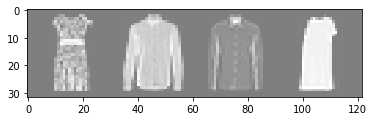

Dress Shirt Shirt Dress


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

from blitz.modules import BayesianLinear, BayesianConv2d
from blitz.losses import kl_divergence_from_nn
from blitz.utils import variational_estimator

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                             download=True,
                                             transform=transforms.Compose([transforms.ToTensor()]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                            download=True,
                                            transform=transforms.Compose([transforms.ToTensor()]))
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = (
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Initialize tensorboard
writer = SummaryWriter('runs/fashion_mnist')


# get some random training images
dataiter = iter(trainloader)
testImages, testLabels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(testImages))
# print labels
print(' '.join('%5s' % classes[testLabels[j]] for j in range(4)))

# 2. Define a convolutional neural network


In [2]:
@variational_estimator
class BayesianCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = BayesianConv2d(1, 6, (5,5)) # 6 filters, size 5x5,            output size = 24x24
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = BayesianConv2d(6,16, (3,3)) # 16 filters, size 3x3,           outSize = 10x10

        # Define function
        self.fc1 = BayesianLinear(16*5*5, 160)
        self.fc2 = BayesianLinear(160, 120)
        self.fc3 = BayesianLinear(120, 84)
        self.fc4 = BayesianLinear(84, 10)

    def forward(self, x):
        # First convolution and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

def evaluate_classifier(classifier, X, y, samples=100, std_multiplier=2):
    preds = [classifier(X) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    stds = preds.std(axis=0)


    return preds, means, stds



# 3. Define a Loss function and optimizer and train the network

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier = BayesianCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
plot_step = 0

for epoch in range (2):
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss = classifier.sample_elbo(inputs=inputs.to(device),
        labels=labels.to(device),
        criterion=criterion,
        sample_nbr=3,
        complexity_cost_weight = 1/50000)

        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
            # Add data to tensorboard
            writer.add_scalar("Loss/train", loss, plot_step)

            #preds, means, stds = evaluate_classifier(classifier, testImages, testLabels)

            #print(means)

            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    outputs = classifier(images.to(device))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels.to(device)).sum().item()
            print('[%d, %5d] loss: %.3f' % (epoch, i, loss))
            print("The accuracy is: {} %".format(str(100* correct / total)))
            plot_step = plot_step + 1

print('Finished training')
writer.flush()

# Save data
PATH = './model/trained_koen_bay.pth'
torch.save(classifier.state_dict(), PATH)



[0,     0] loss: 11.222
The accuracy is: 10.0 %
[0,  1000] loss: 9.198
The accuracy is: 73.47 %


# 4. Test the network

In [6]:
PATH = './model/trained_koen_bay.pth'
dataiter = iter(testloader)
images, labels = dataiter.next()

# load the trained model
classifier = BayesianCNN()
classifier.load_state_dict(torch.load(PATH))

outputs = classifier(images.to(device))

#print(pred)
print(outputs.data)

# pints images
imshow(torchvision.utils.make_grid(images))
print('Ground truth: ', ' '.join('%5f' % labels[j] for j in range(4)))

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = classifier(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print("The accuracy is: {} %".format(str(100* correct / total)))


KeyboardInterrupt: 

# 4. Create tensorboard


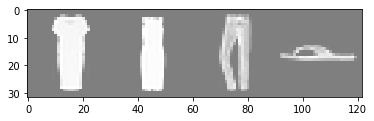

In [55]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

img_grid = torchvision.utils.make_grid(images)

imshow(img_grid)

writer.add_image('four_fashion_mnist_images', img_grid)
writer.add_graph(net, images)
writer.close()

